In [ ]:
from pyspark.sql.functions import col,  date_format, col,  lag, when,   mean, round
from pyspark.sql.window import Window
import os

# configs
storage_account_name = os.environ.get('storage_account_name')
storage_account_key = os.environ.get("storage_account_key")
container_name = os.environ.get("container_name")

# timeseries technical indicators params
ema_period = 14
rsi_period = 14

symbols = [
    'BTCUSDT',
    'ETHUSDT',
    'BNBUSDT',
    'ETHBTC',
    'BNBETH',
    'BNBBTC',
]


def calculate_ema(df, column,  period):
    alpha = 2 / (period + 1)
    ema = df.withColumn("prev_ema", lag(column, 1).over(Window.orderBy('Close time')))
    ema = ema.withColumn("ema", when(col("prev_ema").isNull(), col(column)).otherwise(alpha * col("Close") + (1 - alpha) * col("prev_ema")))
    return ema


def calculate_rsi(df, column, period):
    delta = col(column) - lag(column, 1).over(Window.orderBy('Close time'))
    gain = when(delta > 0, delta).otherwise(0)
    loss = when(delta < 0, -delta).otherwise(0)
    avg_gain = mean(gain).over(Window.partitionBy().orderBy('Close time').rowsBetween(-period, 0))
    avg_loss = mean(loss).over(Window.partitionBy().orderBy('Close time').rowsBetween(-period, 0))
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return df.withColumn("rsi", rsi)

In [ ]:

symbols_and_idx_df = None
abfss_url = f"abfss://{container_name}@{storage_account_name}.dfs.core.windows.net/"

# calculate rsi of ema for each pair and join into single df
for symbol in symbols:
    blob_name = f"layers/silver/{symbol}.parquet"
    df = spark.read.parquet(f"{abfss_url}/{blob_name}")
    df = calculate_ema(df, "Close", ema_period)
    df = calculate_rsi(df, "ema", rsi_period)

    rsi = df.select("Close time", "rsi").withColumnRenamed("rsi", f"{symbol}")
    if symbols_and_idx_df is None:
        symbols_and_idx_df = df.select("Close Time")

    symbols_and_idx_df = symbols_and_idx_df.join(rsi, on="Close time")

# calcualte indexes for symbols
symbols_and_idx_df = (
    symbols_and_idx_df.withColumn(
        "BTC", (col("BTCUSDT") + (100 - col("ETHBTC")) + (100 - col("BNBBTC"))) / 3
    )
    .withColumn("ETH", (col("ETHUSDT") + col("ETHBTC") + (100 - col("BNBETH"))) / 3)
    .withColumn("BNB", (col("BNBUSDT") + col("BNBETH") + (100 - col("BNBBTC"))) / 3)
    .withColumn(
        "USDT",
        ((100 - col("BTCUSDT")) + (100 - col("ETHUSDT")) + (100 - col("BNBUSDT"))) / 3,
    )
)
symbols_and_idx_df = symbols_and_idx_df.dropna()

In [ ]:
#  format columns
symbols_and_idx_df = symbols_and_idx_df.withColumn('Close time', date_format(col('Close time'), "yyyy-MM-dd HH:mm"))

for col_name, col_type in symbols_and_idx_df.dtypes:
    if col_type == 'double':
        symbols_and_idx_df = symbols_and_idx_df.withColumn(col_name, round(col_name, 2))

# load parquet df to azure data storage
blob_name_to_write = f"layers/gold/symbols.parquet"
symbols_and_idx_df.write\
    .format("parquet")\
    .option('header', 'true')\
    .mode('overwrite')\
    .save(f'{abfss_url}/{blob_name_to_write}')

display(symbols_and_idx_df)

Close time,BTCUSDT,ETHUSDT,BNBUSDT,ETHBTC,BNBETH,BNBBTC,BTC,ETH,BNB,USDT
2023-11-25 23:59,64.23,74.35,34.73,94.06,7.94,11.81,52.79,86.83,43.62,42.23
2023-11-26 23:59,64.35,74.1,36.55,91.33,11.73,15.0,52.67,84.57,44.42,41.67
2023-11-27 23:59,59.71,67.82,34.04,84.87,11.52,14.47,53.46,80.39,43.7,46.14
2023-11-28 23:59,58.37,61.49,31.42,65.15,11.4,13.09,60.05,71.75,43.24,49.57
2023-11-29 23:59,62.58,63.4,33.94,57.58,11.39,12.51,64.16,69.86,44.27,46.69
2023-11-30 23:59,62.68,60.72,32.62,50.71,11.24,11.76,66.74,66.73,44.03,47.99
2023-12-01 23:59,62.79,63.51,33.13,58.81,10.55,12.55,63.81,70.59,43.71,46.86
2023-12-02 23:59,68.62,67.35,34.23,55.05,9.54,11.03,67.51,70.95,44.25,43.27
2023-12-03 23:59,72.07,72.39,34.63,62.36,8.17,10.06,66.55,75.52,44.25,40.31
2023-12-04 23:59,74.43,73.79,34.31,59.9,7.74,9.29,68.41,75.32,44.26,39.16


Databricks visualization. Run in Databricks to view.

/root/.ipykernel/855/command-3935432307945626-3414964816:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)
/root/.ipykernel/855/command-3935432307945626-3414964816:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)


[Text(19737.0, 0, '2024-01-15'),
 Text(19744.0, 0, '2024-01-22'),
 Text(19754.0, 0, '2024-02-01'),
 Text(19761.0, 0, '2024-02-08'),
 Text(19768.0, 0, '2024-02-15'),
 Text(19775.0, 0, '2024-02-22')]

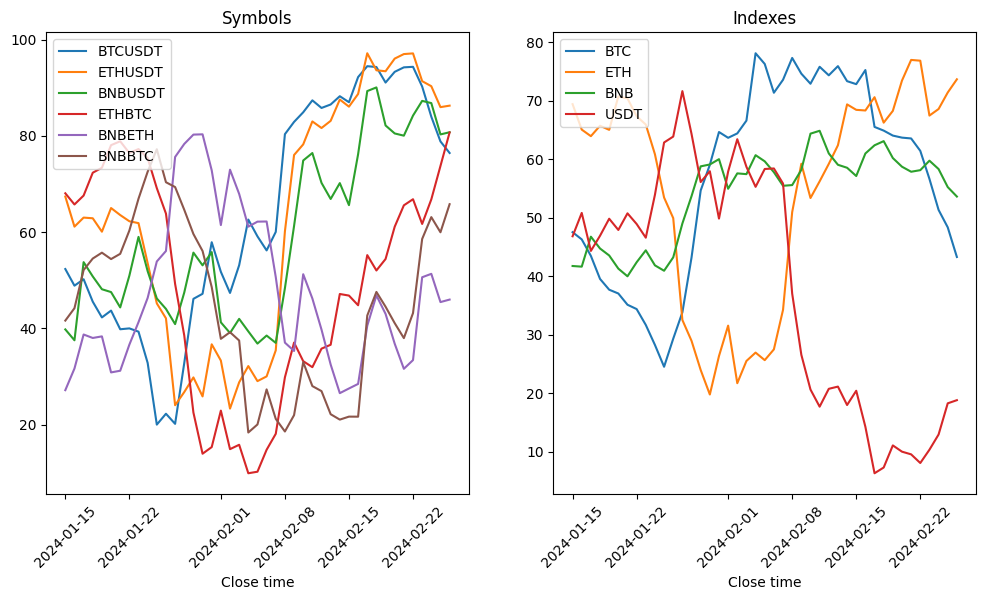

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculate correlation matrix for the sliced dataframe
pairs_df = symbols_and_idx_df.select(symbols + ['Close time']).toPandas()
pairs_df['Close time'] = pd.to_datetime(pairs_df['Close time'])
pairs_df.index = pairs_df['Close time']

idxs_df = symbols_and_idx_df.drop(*symbols).toPandas()
idxs_df['Close time'] = pd.to_datetime(idxs_df['Close time'])
idxs_df.index = pairs_df['Close time']

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot line graph with solid lines
sns.lineplot(data=pairs_df[50:], dashes=False, ax=axes[0])
axes[0].legend(loc='upper left')
axes[0].set_title('Symbols')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)

# Plot line graph with solid lines
sns.lineplot(data=idxs_df[50:], dashes=False, ax=axes[1])
axes[1].legend(loc='upper left')
axes[1].set_title('Indexes')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)

/root/.ipykernel/855/command-3935432307945632-153085432:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pairs_df.reset_index(drop=True).corr(), annot=True, ax=axes[0])
/root/.ipykernel/855/command-3935432307945632-153085432:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(idxs_df.reset_index(drop=True).corr(), annot=True, ax=axes[1])


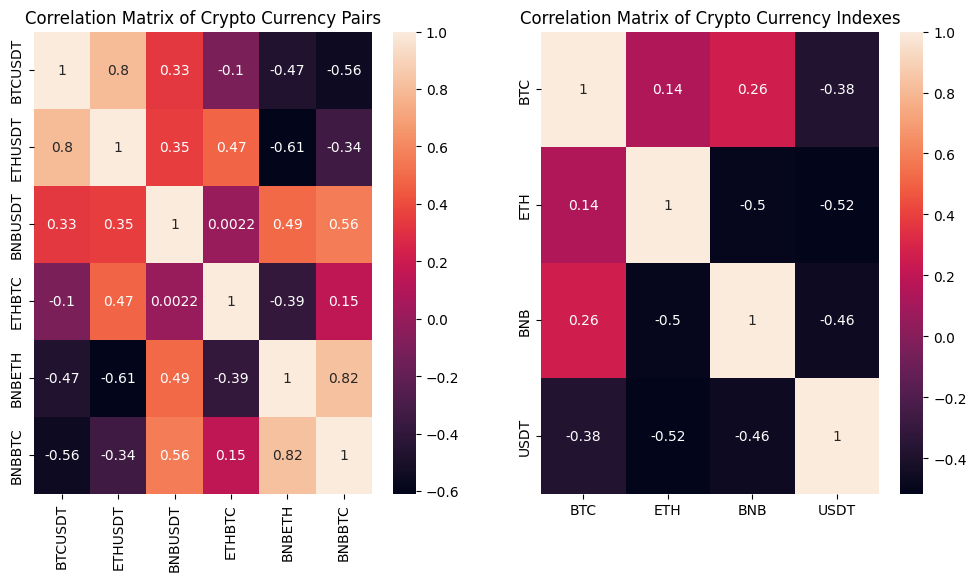

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot correlation matrix of the sliced dataframe as heatmap in the first subplot
sns.heatmap(pairs_df.reset_index(drop=True).corr(), annot=True, ax=axes[0])
axes[0].set_title('Correlation Matrix of Crypto Currency Pairs')

# Plot correlation matrix of the remaining columns as heatmap in the second subplot
sns.heatmap(idxs_df.reset_index(drop=True).corr(), annot=True, ax=axes[1])
axes[1].set_title('Correlation Matrix of Crypto Currency Indexes')

# Display the plots
plt.show()

/root/.ipykernel/855/command-3935432307945631-198351245:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = symbols_and_idx_df.toPandas().corr()


<Axes: >

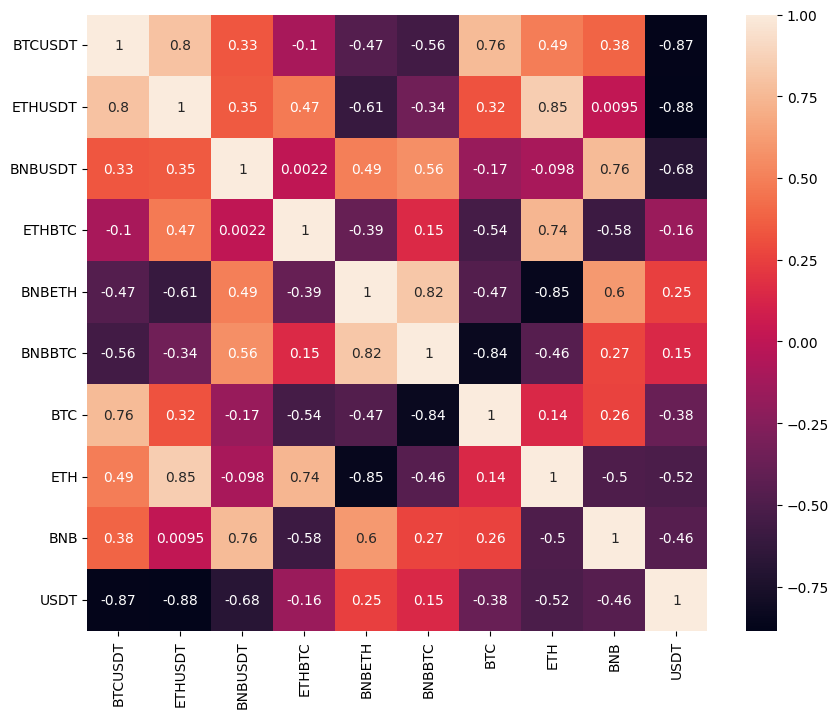

In [ ]:
# Set size for the heatmap plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a correlation matrix from the symbols_and_idx_df dataframe
correlation_matrix = symbols_and_idx_df.toPandas().corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, ax=ax)